In [7]:
import os
import numpy as np
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch 
import time
from audioldm import build_model
from audioldm.latent_diffusion.ddim import DDIMSampler
from audioldm.pipeline import duration_to_latent_t_size
from tqdm.notebook import tqdm

from utils.utils import *
sr = 16000



#test


In [8]:
model = build_model(model_name="audioldm-m-full")

torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

modelmem = torch.cuda.memory_allocated() / (1024 * 1024) 

print(f"{modelmem} MiB")
# print(torch.cuda.memory_summary())


Load AudioLDM: %s audioldm-m-full


DiffusionWrapper has 415.95 M params.


/home/jovyan/project/MultiDiffusionAudio/ldmenv/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


8897.9404296875 MiB


In [ ]:
model.cond_stage_model.embed_mode = "text"

# 🎵 TEMPORAL PROMPT SEGMENTATION - Simple segments for crossfading
# TEMPORAL PROMPTS: Simple, separate segments for crossfading
duration = 30.0  # seconds

# Define time segments with simple, distinct prompts (NO combined concepts!)
prompt = "90s rock song with electric guitar and heavy drums"

print("🎭 CREATING SIMPLE SEGMENT PROMPT EMBEDDINGS:")

pemb = model.get_learned_conditioning(prompt)


# Create unconditional embedding
unconditional_text = [""] 
unconditional_embedding = model.get_learned_conditioning(unconditional_text)


🎭 CREATING SIMPLE SEGMENT PROMPT EMBEDDINGS:


# End-to-End Text-to-Sound Pipeline

This notebook implements a **MultiDiffusion** extension of DDIM to generate long-form audio from text:

1. **Text → Embedding**: Convert prompt to conditioning vectors via CLAP.
2. **Latent Noise Initialization**: Sample `z` of shape `[1, C, T, F]`.
3. **Scheduler Setup (DDIM)**: Call `sampler.make_schedule()` for timesteps.
4. **MultiDiffusion Chunking** (75% overlap): Split latent along time into overlapping chunks.
5. **Per-Chunk U-Net**: Run model to predict noise for each padded chunk (with CFG).
6. **Overlap-Average**: Merge chunk noise predictions into one full tensor.
7. **Single-Tensor DDIM Step**: Apply DDIM reverse-diffusion math to full tensor.
8. **Repeat** for all timesteps → final latent `x_0`.
9. **VAE Decode**: `x_0` → mel-spectrogram via VAE.
10. **Vocoder**: Convert mel to waveform audio for playback.

---


DEBUG: total_frames=512, chunk_size=256, overlap_frames=192, advance_step=64
DEBUG: chunk 1: (0, 256) - frames: 256
DEBUG: chunk 2: (64, 320) - frames: 256
DEBUG: chunk 3: (128, 384) - frames: 256
DEBUG: chunk 4: (192, 448) - frames: 256
DEBUG: chunk 5: (256, 512) - frames: 256
DEBUG: Created 5 chunks covering frames 0-512
LONG AUDIO: Using MultiDiffusion with 5 chunks, overlap=192


Diffusion Steps: 100%|██████████| 200/200 [00:39<00:00,  5.07it/s]


Diffusion time: 121.75s, peak mem: 4707.9 MiB, curr mem: 4462.3 MiB
Final latent shape: torch.Size([1, 8, 512, 16])
✅ Diffusion latent output is clean (no NaN/Inf)


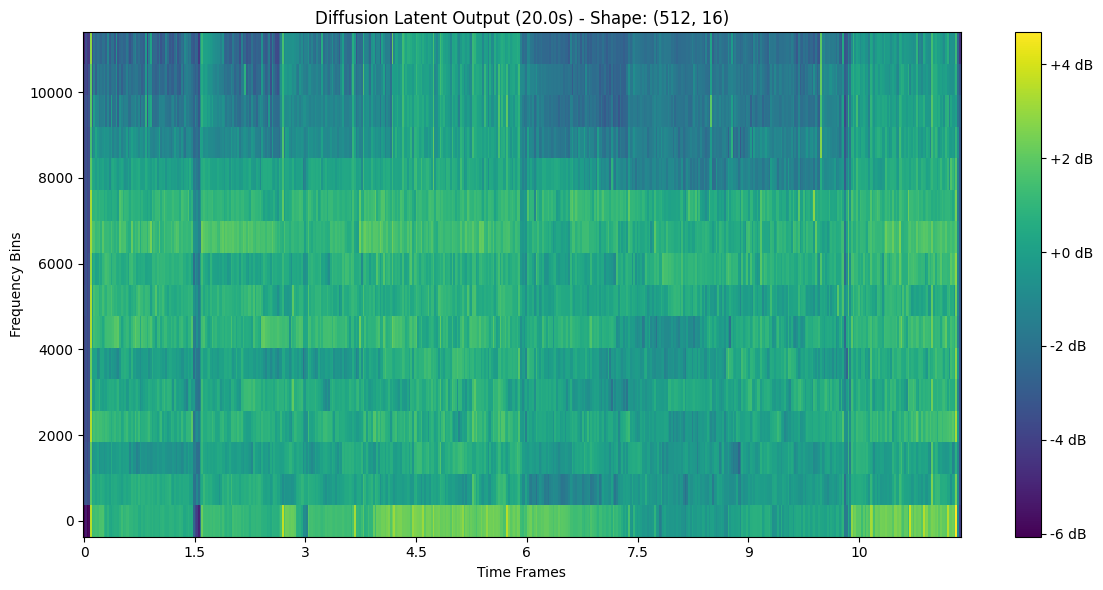

Latent stats - Min: -6.066, Max: 4.680, Mean: 0.024, Std: 1.178


In [ ]:
# Run MultiDiffusion Diffusion Loop with Crossfading
## Set parameters
ddim_steps = 200
ddim_eta = 0.0
unconditional_guidance_scale = 3.0
chunk_frames = 256
overlap_frames = int(chunk_frames * 0.75)

# Scheduler and initial noise
sampler = DDIMSampler(model)
latent_size = duration_to_latent_t_size(duration)
shape = [1, model.channels, latent_size, model.latent_f_size]
z = torch.randn(shape).to(model.device)


with torch.no_grad():
    samples = multidiffusion_sample_clean(
        sampler=sampler,
        shape=shape,
        conditioning=pemb,
        unconditional_conditioning=unconditional_embedding,
        unconditional_guidance_scale=unconditional_guidance_scale,
        eta=ddim_eta,
        x_T=z,
        S=ddim_steps,
        chunk_frames=chunk_frames,
        overlap_frames=overlap_frames
    )
torch.cuda.synchronize()

# Display final latent
print(f"Final latent shape: {samples.shape}")
plot_latent_spectrogram(samples, f"Diffusion Latent Output ({duration}s)")

🪟 USING SLIDING WINDOW VAE DECODER:
  Input shape: torch.Size([1, 8, 512, 16])
  Window size: 256 frames (~10.0s)
  Overlap size: 64 frames (~2.5s)
  Step size: 192 frames
  Number of windows: 3
    Window 1: latent[0:256] -> mel shape torch.Size([1, 1, 1024, 64])
    Window 2: latent[192:448] -> mel shape torch.Size([1, 1, 1024, 64])
    Window 3: latent[384:512] -> mel shape torch.Size([1, 1, 512, 64])
  Mel scale factor: 4.00x
  Output mel shape: [1, 1, 2048, 64]
    Added window 1 to output[0:1024]
    Added window 2 to output[768:1792]
    Added window 3 to output[1536:2048]

📊 SLIDING WINDOW VAE PERFORMANCE:
SLIDING WINDOW VAE ISOLATED PEAK: 4718.8 MiB (cost: +256.5 MiB)
SLIDING WINDOW VAE CURRENT MEMORY: 4462.3 MiB
SLIDING WINDOW VAE TIME: 0.0s

🔍 SLIDING WINDOW VAE OUTPUT ANALYSIS:
Mel spectrogram shape: torch.Size([1, 1, 2048, 64])
Latent → Mel conversion factor: 4.00x
Mel frames: 2048
Expected mel duration: 20.48s
✅ Sliding window VAE mel spectrogram output is clean (no NaN/I

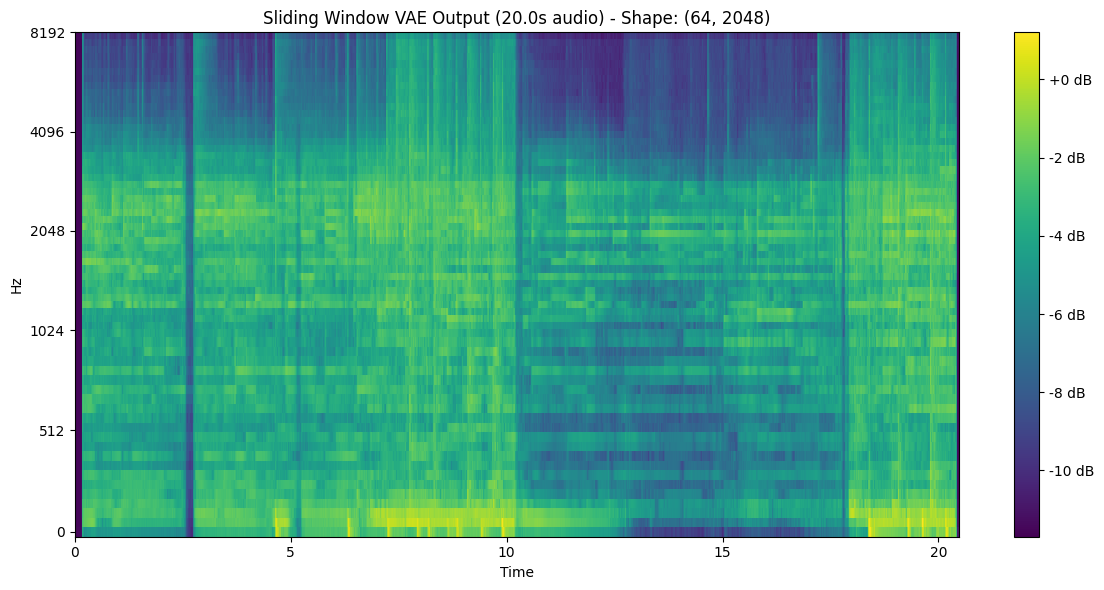

Mel stats - Min: -11.698, Max: 1.206, Mean: -4.757, Std: 2.195


In [19]:
# VAE DECODER - Using Sliding Window approach for memory efficiency
# Get memory before VAE and reset peak tracker
memory_before_vae = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

print("🪟 USING SLIDING WINDOW VAE DECODER:")

# Define sliding window VAE function
def sliding_window_vae_decode(model, latents, window_size=256, overlap_size=64):
    """
    Decode latents using sliding windows with overlap-add reconstruction.
    
    Args:
        model: AudioLDM model with VAE decoder
        latents: Input latent tensor [B, C, T, F]
        window_size: Size of each window in latent frames (default: 256 ~= 10s)
        overlap_size: Overlap between windows in frames (default: 64 ~= 2.5s)
    
    Returns:
        Reconstructed mel spectrogram
    """
    device = latents.device
    B, C, T, F = latents.shape
    
    print(f"  Input shape: {latents.shape}")
    print(f"  Window size: {window_size} frames (~{window_size/25.6:.1f}s)")
    print(f"  Overlap size: {overlap_size} frames (~{overlap_size/25.6:.1f}s)")
    
    # If input is smaller than window, use regular decoding
    if T <= window_size:
        print(f"  Input smaller than window - using regular decode")
        return model.decode_first_stage(latents)
    
    # Calculate windows
    step_size = window_size - overlap_size
    num_windows = (T - overlap_size + step_size - 1) // step_size
    
    print(f"  Step size: {step_size} frames")
    print(f"  Number of windows: {num_windows}")
    
    # Process each window
    windows = []
    window_positions = []
    
    for i in range(num_windows):
        start = i * step_size
        end = min(start + window_size, T)
        actual_window_size = end - start
        
        # Extract window
        window_latent = latents[:, :, start:end, :]
        
        # Decode window
        with torch.no_grad():
            window_mel = model.decode_first_stage(window_latent)
        
        windows.append(window_mel)
        window_positions.append((start, end, actual_window_size))
        
        print(f"    Window {i+1}: latent[{start}:{end}] -> mel shape {window_mel.shape}")
    
    # Calculate output dimensions
    mel_scale_factor = windows[0].shape[2] / window_positions[0][2]  # mel_frames / latent_frames
    total_mel_frames = int(T * mel_scale_factor)
    mel_channels = windows[0].shape[1]
    mel_freq_bins = windows[0].shape[3]
    
    print(f"  Mel scale factor: {mel_scale_factor:.2f}x")
    print(f"  Output mel shape: [{B}, {mel_channels}, {total_mel_frames}, {mel_freq_bins}]")
    
    # Initialize output tensor and weight accumulator
    output_mel = torch.zeros((B, mel_channels, total_mel_frames, mel_freq_bins), 
                            device=device, dtype=windows[0].dtype)
    weight_sum = torch.zeros_like(output_mel)
    
    # Create overlap-add weights (linear fade in/out)
    overlap_mel_size = int(overlap_size * mel_scale_factor)
    
    for i, (window_mel, (start, end, actual_size)) in enumerate(zip(windows, window_positions)):
        # Calculate mel positions
        mel_start = int(start * mel_scale_factor)
        mel_end = int(end * mel_scale_factor)
        actual_mel_size = window_mel.shape[2]
        
        # Create weight mask for this window
        weight_mask = torch.ones((1, 1, actual_mel_size, 1), device=device)
        
        # Apply fade-in at the beginning (except for first window)
        if i > 0 and overlap_mel_size > 0:
            fade_in_size = min(overlap_mel_size, actual_mel_size // 2)
            fade_in = torch.linspace(0, 1, fade_in_size, device=device)
            weight_mask[:, :, :fade_in_size, :] = fade_in.view(1, 1, -1, 1)
        
        # Apply fade-out at the end (except for last window)
        if i < len(windows) - 1 and overlap_mel_size > 0:
            fade_out_size = min(overlap_mel_size, actual_mel_size // 2)
            fade_out = torch.linspace(1, 0, fade_out_size, device=device)
            weight_mask[:, :, -fade_out_size:, :] = fade_out.view(1, 1, -1, 1)
        
        # Add weighted window to output
        mel_end_actual = mel_start + actual_mel_size
        output_mel[:, :, mel_start:mel_end_actual, :] += window_mel * weight_mask
        weight_sum[:, :, mel_start:mel_end_actual, :] += weight_mask
        
        print(f"    Added window {i+1} to output[{mel_start}:{mel_end_actual}]")
    
    # Normalize by weight sum to complete overlap-add
    output_mel = output_mel / torch.clamp(weight_sum, min=1e-8)
    
    return output_mel

# Run Sliding Window VAE (replacing the regular decode_first_stage call)
start_time = time.time()
with torch.no_grad(): 
    mel_spectrogram = sliding_window_vae_decode(model, samples, window_size=256, overlap_size=64)
torch.cuda.synchronize()
vae_time = time.time() - start_time

# Get memory usage
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_vae

print(f"\n📊 SLIDING WINDOW VAE PERFORMANCE:")
print(f"SLIDING WINDOW VAE ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"SLIDING WINDOW VAE CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"SLIDING WINDOW VAE TIME: {vae_time:.1f}s")

# 🔍 VAE DECODER OUTPUT ANALYSIS & VISUALIZATION
print(f"\n🔍 SLIDING WINDOW VAE OUTPUT ANALYSIS:")
print(f"Mel spectrogram shape: {mel_spectrogram.shape}")
print(f"Latent → Mel conversion factor: {mel_spectrogram.shape[2] / samples.shape[2]:.2f}x")
print(f"Mel frames: {mel_spectrogram.shape[2]}")
print(f"Expected mel duration: {mel_spectrogram.shape[2] / 100:.2f}s")  # Using 100 fps for AudioLDM
check_for_nan_inf(mel_spectrogram, "Sliding window VAE mel spectrogram output")

# Display mel spectrogram
print(f"\n📊 MEL SPECTROGRAM (from Sliding Window VAE):")
plot_mel_spectrogram(mel_spectrogram, f"Sliding Window VAE Output ({duration}s audio)", sr=sr)

In [20]:
# VOCODER - Using standard approach for now (will optimize later)
memory_before_vocoder = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

start_time = time.time()
with torch.no_grad(): 
    waveform = model.mel_spectrogram_to_waveform(mel_spectrogram)
    # Handle both PyTorch tensors and NumPy arrays
    if isinstance(waveform, torch.Tensor):
        if waveform.dim() > 1:
            waveform = waveform[0]  # Take first batch item: [B, samples] -> [samples]
        waveform = waveform.squeeze()  # Remove any extra dimensions
    else:  # NumPy array
        if waveform.ndim > 1:
            waveform = waveform[0]  # Take first batch item: [B, samples] -> [samples]
        waveform = waveform.squeeze()  # Remove any extra dimensions
torch.cuda.synchronize()
vocoder_time = time.time() - start_time

# Get memory usage
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_vocoder

print(f"VOCODER ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"VOCODER CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"VOCODER TIME: {vocoder_time:.1f}s")

print(f"\nFINAL RESULTS:")
print(f"Generated {duration}s audio with MultiDiffusion")
print(f"Audio shape: {waveform.shape}")
print(f"Audio duration (samples): {len(waveform) / sr:.1f}s")
print(f"Expected samples for {duration}s: {int(duration * sr)}")
print(f"Actual samples: {len(waveform)}")
print(f"Duration discrepancy: {(len(waveform) / sr) - duration:.3f}s")
print(f"Mel → Audio conversion factor: {len(waveform) / mel_spectrogram.shape[2]:.1f}x")
print(f"Overall latent → audio factor: {len(waveform) / samples.shape[2]:.1f}x")

ipd.display(ipd.Audio(waveform, rate=sr))


VOCODER ISOLATED PEAK: 4742.5 MiB (cost: +280.2 MiB)
VOCODER CURRENT MEMORY: 4462.3 MiB
VOCODER TIME: 0.0s

FINAL RESULTS:
Generated 20.0s audio with MultiDiffusion
Audio shape: (327712,)
Audio duration (samples): 20.5s
Expected samples for 20.0s: 320000
Actual samples: 327712
Duration discrepancy: 0.482s
Mel → Audio conversion factor: 160.0x
Overall latent → audio factor: 640.1x


In [13]:
# import soundfile as sf

# # Ensure waveform is a NumPy array and has the correct shape
# waveform = waveform.squeeze()  # Remove batch dimension if present
# if isinstance(waveform, torch.Tensor):
#     waveform = waveform.cpu().numpy()  # Convert to NumPy array if it's a PyTorch tensor

# # Save the generated audio to a file
# output_path = "../output/generation"
# os.makedirs(output_path, exist_ok=True)
# filename = f"multidiff02%.wav"  # Simplify filename
# sf.write(os.path.join(output_path, filename), waveform, sr)

# print(f"Audio saved to {os.path.join(output_path, filename)}")

In [14]:
# 🆚 COMPARISON: Temporal vs Clean MultiDiffusion
# Let's compare both methods with the same single prompt to see performance differences

import time
from utils.utils import multidiffusion_sample_clean

# Test parameters
test_duration = 10.0  # Keep it short for quick comparison
test_prompt = "90s rock song"
chunk_frames = 256
overlap_frames = int(chunk_frames * 0.50)

print("🆚 COMPARING TEMPORAL vs CLEAN MULTIDIFFUSION")
print(f"Duration: {test_duration}s")
print(f"Prompt: '{test_prompt}'")
print(f"Chunk frames: {chunk_frames}, Overlap: {overlap_frames}")
print("=" * 60)

# Setup common parameters
latent_size = duration_to_latent_t_size(test_duration)
shape = [1, model.channels, latent_size, model.latent_f_size]
ddim_steps = 100  # Reduced for faster comparison
ddim_eta = 0.1
unconditional_guidance_scale = 3.0

# Create single prompt embedding (same for both methods)
single_prompt_embedding = model.get_learned_conditioning([test_prompt])
print(f"Generated embedding for: '{test_prompt}'")

# Reset memory stats before comparison
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

print("\n🕐 TESTING CLEAN MULTIDIFFUSION...")
print("-" * 40)

# Test 1: Clean MultiDiffusion
start_time = time.time()
memory_before = torch.cuda.memory_allocated() / (1024 * 1024)

# Create sampler
sampler_clean = DDIMSampler(model)
z_clean = torch.randn(shape).to(model.device)

with torch.no_grad():
    samples_clean = multidiffusion_sample_clean(
        sampler=sampler_clean,
        shape=shape,
        conditioning=single_prompt_embedding,
        unconditional_conditioning=unconditional_embedding,
        unconditional_guidance_scale=unconditional_guidance_scale,
        eta=ddim_eta,
        x_T=z_clean,
        S=ddim_steps,
        chunk_frames=chunk_frames,
        overlap_frames=overlap_frames
    )

torch.cuda.synchronize()
clean_time = time.time() - start_time
clean_peak_mem = torch.cuda.max_memory_allocated() / (1024 * 1024)
clean_mem_usage = clean_peak_mem - memory_before

print(f"✅ CLEAN MULTIDIFFUSION RESULTS:")
print(f"   Time: {clean_time:.1f}s")
print(f"   Peak memory: {clean_peak_mem:.1f} MiB (+{clean_mem_usage:.1f} MiB)")
print(f"   Output shape: {samples_clean.shape}")

# Reset memory for next test
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

print("\n🕐 TESTING TEMPORAL MULTIDIFFUSION...")
print("-" * 40)

# Test 2: Temporal MultiDiffusion (with single segment)
start_time = time.time()
memory_before = torch.cuda.memory_allocated() / (1024 * 1024)

# Create sampler
sampler_temporal = DDIMSampler(model)
z_temporal = torch.randn(shape).to(model.device)

# Create single segment for temporal (same prompt for entire duration)
temporal_segments = [(0.0, test_duration, test_prompt)]
temporal_embeddings = [single_prompt_embedding]

with torch.no_grad():
    samples_temporal = multidiffusion_sample_temporal(
        sampler=sampler_temporal,
        shape=shape,
        segment_embeddings=temporal_embeddings,
        prompt_segments=temporal_segments,
        unconditional_conditioning=unconditional_embedding,
        unconditional_guidance_scale=unconditional_guidance_scale,
        eta=ddim_eta,
        x_T=z_temporal,
        S=ddim_steps,
        chunk_frames=chunk_frames,
        overlap_frames=overlap_frames,
        duration=test_duration
    )

torch.cuda.synchronize()
temporal_time = time.time() - start_time
temporal_peak_mem = torch.cuda.max_memory_allocated() / (1024 * 1024)
temporal_mem_usage = temporal_peak_mem - memory_before

print(f"✅ TEMPORAL MULTIDIFFUSION RESULTS:")
print(f"   Time: {temporal_time:.1f}s")
print(f"   Peak memory: {temporal_peak_mem:.1f} MiB (+{temporal_mem_usage:.1f} MiB)")
print(f"   Output shape: {samples_temporal.shape}")

# Performance comparison
print("\n📊 PERFORMANCE COMPARISON:")
print("=" * 60)
print(f"Clean MultiDiffusion:    {clean_time:.1f}s, {clean_mem_usage:.1f} MiB")
print(f"Temporal MultiDiffusion: {temporal_time:.1f}s, {temporal_mem_usage:.1f} MiB")
print(f"Time difference:         {temporal_time - clean_time:+.1f}s ({((temporal_time/clean_time - 1) * 100):+.1f}%)")
print(f"Memory difference:       {temporal_mem_usage - clean_mem_usage:+.1f} MiB")

if temporal_time > clean_time * 1.1:
    print("⚠️  TEMPORAL is significantly slower")
elif clean_time > temporal_time * 1.1:
    print("⚠️  CLEAN is significantly slower")
else:
    print("✅ Both methods have similar performance")

print("\n🔍 IMPLEMENTATION DIFFERENCES:")
print("Clean MultiDiffusion:")
print("  • Single prompt for all chunks")
print("  • Simple overlap averaging")
print("  • No segment assignment logic")
print("")
print("Temporal MultiDiffusion:")
print("  • Assigns prompts to time segments")
print("  • Chunk center → segment mapping")
print("  • Same overlap averaging (no crossfade in current version)")
print("  • Additional overhead for segment assignment")

🆚 COMPARING TEMPORAL vs CLEAN MULTIDIFFUSION
Duration: 10.0s
Prompt: '90s rock song'
Chunk frames: 256, Overlap: 128
Generated embedding for: '90s rock song'

🕐 TESTING CLEAN MULTIDIFFUSION...
----------------------------------------
SHORT AUDIO: 256 frames <= 256 chunk size - using standard DDIM


Diffusion Steps: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


✅ CLEAN MULTIDIFFUSION RESULTS:
   Time: 4.0s
   Peak memory: 4706.4 MiB (+244.7 MiB)
   Output shape: torch.Size([1, 8, 256, 16])

🕐 TESTING TEMPORAL MULTIDIFFUSION...
----------------------------------------
  Chunk 1: frames[0:256] time[0.0-10.0s] CENTER=5.0s -> '90s rock song' (seg 0)
  Chunk 2: frames[128:256] time[5.0-10.0s] CENTER=7.5s -> '90s rock song' (seg 0)
🎭 TEMPORAL MULTIDIFFUSION: Processing 2 chunks with clean boundaries (no crossfading).


Temporal Diffusion: 100%|██████████| 100/100 [00:07<00:00, 12.62it/s]

✅ TEMPORAL MULTIDIFFUSION RESULTS:
   Time: 7.9s
   Peak memory: 4707.2 MiB (+245.2 MiB)
   Output shape: torch.Size([1, 8, 256, 16])

📊 PERFORMANCE COMPARISON:
Clean MultiDiffusion:    4.0s, 244.7 MiB
Temporal MultiDiffusion: 7.9s, 245.2 MiB
Time difference:         +3.9s (+98.4%)
Memory difference:       +0.5 MiB
⚠️  TEMPORAL is significantly slower

🔍 IMPLEMENTATION DIFFERENCES:
Clean MultiDiffusion:
  • Single prompt for all chunks
  • Simple overlap averaging
  • No segment assignment logic

Temporal MultiDiffusion:
  • Assigns prompts to time segments
  • Chunk center → segment mapping
  • Same overlap averaging (no crossfade in current version)
  • Additional overhead for segment assignment
